# Text generation with LSTM

This notebook is based on the code samples found in Chapter 8, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) and hosted on https://github.com/fchollet/deep-learning-with-python-notebooks. Note that the original text features far more content, in particular further explanations and figures.


In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
tf.keras.__version__

'2.2.4-tf'

## Implementing character-level LSTM text generation


Let's use Keras to generate text. The first thing we need is a lot of text data that we can use to learn a 
language model. You could use any sufficiently large text file or set of text files -- Wikipedia, the Lord of the Rings, etc. In this 
example we will use some of the writings of Nietzsche, the late-19th century German philosopher (translated to English). The language model 
we will learn will thus be specifically a model of Nietzsche's writing style and topics of choice, rather than a more generic model of the 
English language.

## Preparing the data

Let's start by downloading the corpus and converting it to lowercase:

In [4]:
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length:', len(text))

Corpus length: 600893


Using TensorFlow backend.


In [5]:
text[:300]

'preface\n\n\nsupposing that truth is a woman--what then? is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to truth, ha'


Next, we will extract partially-overlapping sequences of length `maxlen`, one-hot encode them and pack them in a 3D Numpy array `x` of 
shape `(sequences, maxlen, unique_characters)`. Simultaneously, we prepare a array `y` containing the corresponding targets: the one-hot 
encoded characters that come right after each extracted sequence.

In [6]:
# Length of extracted character sequences
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


In [7]:
sentences[:5]

['preface\n\n\nsupposing that truth is a woman--what then? is the',
 'face\n\n\nsupposing that truth is a woman--what then? is there ',
 'e\n\n\nsupposing that truth is a woman--what then? is there not',
 '\nsupposing that truth is a woman--what then? is there not gr',
 'pposing that truth is a woman--what then? is there not groun']

In [8]:
next_chars[:5]

['r', 'n', ' ', 'o', 'd']

## Building the network

Our network is a single `LSTM` layer followed by a `Dense` classifier and softmax over all possible characters. But let us note that 
recurrent neural networks are not the only way to do sequence data generation; 1D convnets also have proven extremely successful at it in 
recent times.

In [9]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

Since our targets are one-hot encoded, we will use `categorical_crossentropy` as the loss to train the model:

In [10]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

## Training the language model and sampling from it


Given a trained model and a seed text snippet, we generate new text by repeatedly:

* 1) Drawing from the model a probability distribution over the next character given the text available so far
* 2) Reweighting the distribution to a certain "temperature"
* 3) Sampling the next character at random according to the reweighted distribution
* 4) Adding the new character at the end of the available text


The following code shows how we can re-adjust a probability distribution by applying different temperatures. 
* The higher the temperature, the more random the probability distribution.
* The lower the temperature, the more deterministic the probability distribution (closer to a one-hot vector).

In [11]:
probs = np.array([0.1,0.2,0.4,0.3])
probs_1 = np.exp(np.log(probs)/0.1)
probs_1 = probs_1/np.sum(probs_1)
probs_1

array([9.01997925e-07, 9.23645876e-04, 9.45813377e-01, 5.32620755e-02])

In [12]:
probs_2 = np.exp(np.log(probs)/0.01)
probs_2 = probs_2/np.sum(probs_2)
probs_2

array([6.22301528e-61, 7.88860905e-31, 1.00000000e+00, 3.20720219e-13])

In [13]:
probs_3 = np.exp(np.log(probs)/2)
probs_3 = probs_3/np.sum(probs_3)
probs_3

array([0.16270045, 0.23009319, 0.32540091, 0.28180545])

In [14]:
probs_4 = np.exp(np.log(probs)/100)
probs_4 = probs_4/np.sum(probs_4)
probs_4

array([0.24801823, 0.24974333, 0.25148043, 0.25075801])

Below is the sampling function that samples an item from a probability distribution with a temperature:

In [15]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Here is some code that we can use to generate text at varying temperatures as the model is being trained.

In [16]:
import sys
def generate_text(model, text_seed):
    "Generate text given a text seed"
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        generated_text = text_seed
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()    


Finally, this is the loop where we repeatedly train and generate text. We start generating text using a range of different temperatures 
after every epoch. This allows us to see how the generated text evolves as the model starts converging, as well as the impact of 
temperature in the sampling strategy.

In [17]:
import random

loss = []
for epoch in range(1, 60):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    history = model.fit(x, y,
                  batch_size=128,
                  epochs=1)
    loss.append(history.history['loss'])
    
    filename = 'generation_model_epoch%i.h5' % epoch
    model.save_weights(filename)
    print("Model saved in file", filename)

    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    text_seed = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + text_seed + '"')
    generate_text(model, text_seed)


epoch 1
Train on 200278 samples
200278/200278 [==============================] - 8s 40us/sample - loss: 1.9639
Model saved in file generation_model_epoch1.h5
--- Generating with seed: "be made responsible for
nothing, neither for his nature, nor"
------ temperature: 0.2
be made responsible for
nothing, neither for his nature, nor order the hind and and and here and and conterned the some the self it is the proplist of the sense of the world in the some interent the must the dectifice of the mere and the self the sense of the sentime in the soul the superfice of the some the self the the self the superfor the same the doman to the sentiment of the mankind the sentiment the sense of the some and and all the self the distrus
------ temperature: 0.5
be made responsible for
nothing, neither for his nature, nor diffires and condect every somether felled to the dust which the not indepents with the concections of superficed and and ordoust and all the also the very confiries to be hordy in th

fahaly philosophical expendent, and prake clast lastable them taste a mate men and herdinary condective homoser often tenciti
------ temperature: 1.2
 of them towards us has a free will in the matter and that it were h in it general should
sympatheme who us which fachs, for giveres! theorowab.
sens
onely "sarbfreed. on trushacbing cising, perhaps bra of woman, or one's weredvers
look himselfest) is to aur. that cractud labevalus domines,
in: that notwiyen
age:
what may has other intellectual geilinax:warier serrous of wildr--king"". loveianicatual form,
wishes wiser intminal philosopher
ta: becauncticr 
epoch 5
Train on 200278 samples
200278/200278 [==============================] - 6s 31us/sample - loss: 1.4510
Model saved in file generation_model_epoch5.h5
--- Generating with seed: "d too
far below the level of mankind.--much, too, that is fr"
------ temperature: 0.2
d too
far below the level of mankind.--much, too, that is free spiritual the conscious to the consequently and the sta

something which was with them all the existence of churches and away with the general world the cause of himself and as a things in the evilony and bad them aled and their conscience of like a soul, the pain, as the finerant of the same exception of the interpretation. only when the good who that he schooled too degree of the german in when restends and even the most same when attempt, the prompous and of the prese
------ temperature: 1.0
if they are not really trying to win back
something which way findish, thew" desist
even hown be
ruceded their of discomentic would always, and right, and
account, druth of dhy not certain gives hen other and inflic all windis, is to a new
thoughth own secoptic furtie of nehilicishmenlies of good segmet: and still most semethic from their "distinctiti"m, almost far comprehen the friends in advaing many, those who should man: goome findsables. it hape his s
------ temperature: 1.2
if they are not really trying to win back
something which was the famout

181. in the philosophers and supposing the spirit of the spirit of the contrary and all the philosophy and a state of the spirit in the spirit and strong the sensual of the same the structure of the present the astradity of the strength of the present and such a standardeeness of the hasting and the strong still in the case and the spirit of a strong as it is a standart of the delicate and also also a s
------ temperature: 0.5
in lying which is the sign of good faith in a
cause.

181. in the farouse of the falsic sensless of a more an active
continelity: the "faith, like the ask and self-last and interpresed, the present, the most stranges of the philosophy and the philosophy, however, and such an impress to which our spirit with all who has a man is manifested to distoncly with
which is also because of the man should animal with the sake of which tender the philosophy, and the 
------ temperature: 1.0
in lying which is the sign of good faith in a
cause.

181. in it mudy of the
longing

psohe on this reve, which. one gere man (ingreemed in i ex scare"
ideasing and false. never believe the manfours,
as fere would dust brople of the idean fortants nethower, persontune through a consciences "presence), unfatiless paycied", but the
budiateve 
epoch 16
Train on 200278 samples
200278/200278 [==============================] - 6s 32us/sample - loss: 1.3383
Model saved in file generation_model_epoch16.h5
--- Generating with seed: "e!"
what does it matter! and even if they were right--have n"
------ temperature: 0.2
e!"
what does it matter! and even if they were right--have not the senses of the truth and considerations of the sense of the demons the subject and the sense of the sense of the sense of the seriemable of the superiors, and the subject to the same self-servible of a consideration of the sense of the self conscience of the subject and the subject that the standard to the subject than the world and for the senses the seriousness of the self artifice of the 
------ te

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until



------ temperature: 1.2
gs (innre), draw
close to the heart of nature. but these feels homestlerged and rowards.=--footur be such as erment" is also should looked difficulty on ysis.

. dys to look are
fewteeles; criable a depan, goo, more
mogine of nfhorue which mislon"
plebeian, cete" it, which our pattive oblopped general humance to a farther hurt of things
display influence. one had how
your something ask cooe learns shall had hitherto re raw theredoring concesial other let a
epoch 18
Train on 200278 samples
200278/200278 [==============================] - 6s 31us/sample - loss: 1.3287
Model saved in file generation_model_epoch18.h5
--- Generating with seed: ".

144. when a woman has scholarly inclinations there is gen"
------ temperature: 0.2
.

144. when a woman has scholarly inclinations there is general and more an and moral for the same that the most superiority of the contrary and the same the same the same the same the same the comparison of the same the same that the most 

rit is embodied, now large, now small. a stone that suddenly best the full, in the sense, and because the subject and the subject and the strengther and sometipathoge, and clears and same has the rank and pression, and the belief in a great as it is also because the action of the same the the early old man in the fact the sage matist of the very things, and into the subject and the senses the strighted are life and solitude, himself to one must
present in 
------ temperature: 1.0
rit is embodied, now large, now small. a stone that suddenly distinctively how profounds. the fact that the distrust
in. revesiably in it. againly human parity tamin, that, should like it; iffting at light as self nature for even, undistimated optily-for the bad young mythlest
more:
one more dhes intuity lij), the term
mpinged from places still relarly. the purber as
indispensations, the originals, man--what possibility of freedne who to religious schopenh
------ temperature: 1.2
rit is embodied, now large, no

and intercourse with her. in those times nothing is yet knows the sense of the words of the servicted and moral in the same than the subject and the surpless of the same than the same than the world and the subject in the same than the most subtle formerly and condition of the same than the distrustful and the subject in the same to a means of the houty in the present best of the same such as the freedom of the fact the subject the problem of the sense 
------ temperature: 0.5
re
and intercourse with her. in those times nothing is yet knows the dangerous particiated to the states of this great present steplisarion of the distrustful and distract the same suffering to be the paradise contemplation of the appressen to it, as a moral of the sunsequently and such a conducts in the words, and could be profound to its superiorical things there is a states of his truth the deception of the master--and the accordance of the words, and m
------ temperature: 1.0
re
and intercourse with her. in t

you ventrism, dile to the either restomes; as you feels,

 more, and do own to himself whether yet ier mans, and anychrist to a skeptician, the
deepyopones, to be ! cw. what untimed, necessary to a mieworitable with according
to the fellowed that a moral
teach kehom, belief
of the
value, who lifting 
epoch 29
Train on 200278 samples
200278/200278 [==============================] - 6s 31us/sample - loss: 1.2932
Model saved in file generation_model_epoch29.h5
--- Generating with seed: " change of matter, are still synthetically united with
one a"
------ temperature: 0.2
 change of matter, are still synthetically united with
one another which is a sense of the same and the consideration of the sense of the states of the states and best that the point of the warfer in the fact of the sense and same the sense and the sense of the sense of the consequences in the fact of the world as if the most subtle that is not be in the complication of the states of the sense of the sense of the discover

strict regard for the other, the greatly courage. in men. if we mutuol--indeed inarre human state, the
when diwardnessth. therequense the
sakes throws the class, (interate-gone and-injusing that wearty, in fact oui, however--or the aid  hed all the
honore power against the battipated out itself with out and most sign, is the grue when dechation of ock, phyex here which eyorth-rending for exampled to him externation
------ temperature: 1.2
oral inasmuch as they are not done with a
strict regard for instinct, at present actfut love saint
od asleth
re: "fortun-for in rehite of
subtle
treaturours.

1at refurities" wheres, nndy just ma"nbully purely, foreegilism
indiscretence.

ataurately me seniony on liy)s-"-is they, and considered, ap gupinity, and . how cestating ydol
socratisn),
estendy evil, out, fresh: mai passion, has always sylec, amist! why is the man. the names critls" which, apart po
epoch 33
Train on 200278 samples
200278/200278 [==============================] - 6s 31us/sample

resort, false? and if i have the subtlest and the profound and something and something of the things and something state of the same than the subject and the state of the stand that the stands the actions of the domain of the subject when the sense of the same than the subtlest and all the same than the subject and contrast stands and the stands and all the same that the subtlest the subject but the subject the sufferi
------ temperature: 0.5
the devil? is everything, in the last
resort, false? and if i althous like the education of the philosophers, and some as a conduct of his own end to every disparage to soul, the reasonable philosopher things some of the unintered the most end, and domain
of contrast that the concerned even enough to him is knowledge for the strength that the most sense in the contuiles of the higher has stand that should not the consequences, and when he stands all in a w
------ temperature: 1.0
the devil? is everything, in the last
resort, false? and if the trea

neelssome, not "protency to sympty on those part of cause a yet transluth.ifys and his persirn of definitely
disaugured and always? away.


achine is essentially a
comfices it want out as mid higherxquitualer believed and
somigoniar places .


     really co
epoch 40
Train on 200278 samples
200278/200278 [==============================] - 6s 31us/sample - loss: 1.2740
Model saved in file generation_model_epoch40.h5
--- Generating with seed: " let us send to its
help whatever devilry we have in us:--ou"
------ temperature: 0.2
 let us send to its
help whatever devilry we have in us:--outh the sentiment of the senterment of the senterment and sense of the same thing as a matters of the spirit of the same sense of the same things and the sentiment of the senterment and superiority of the sentiment of the sentiment of the same sense of the sentiment of the sentiment and sense of the spirit and sense and superiority of the sentiment of the same the sentiment of the same men of the s
------ 

existence.--in a lizard a finger grows again which has been. the usecintary against such a shoulsertling of the circumsic tumplation of a sad
philonognive spirit. and to --alsot for tomagbys the furthered for light for an aristic after a prove, the will for these de-affected does in thei.


at womanwarden: a true
evil; the most knowledge". out or
to the follies for the one and simply as also embligicity is good, the seemong shexage of semolt states
tot
------ temperature: 1.2
its
existence.--in a lizard a finger grows again which has been visitions, and has find logical helf, must heby likene-deceptomible fined
languorism, by itself of nonet
grasps of invence without each expression becomes uprist: "the danger. and could meseolation? of others.

the weehing. ho do burning and class
bind, which must be cares of
life cases word, his listabpting
so successification (by
such a always there preual of-personroow:

vin
end,
how to chu
epoch 44
Train on 200278 samples
200278/200278 [==========

harshness, and easierating and the same thing and something of the sense is a morality of the sense of the same sentimental things and also the same things as the sense of the same sentimental problem souls as the sense of the sense of the most something and stronger and allowed to the same time and the same sentiment of the same souls and souls and the sense is the same time and stronger things as a present of the 
------ temperature: 0.5
volence which is capable of severity and
harshness, and easient for in the precisely that something and the really and repulsic scely moved be be the brind and such things also an instincts of the souls and that significance which has been the latter soul, as a man is much struggeriate and spirit of the spirit of the only
souls, is the good in regards of the other impossible is a truth and personal as it are strong as an actions and states of the curiosity
------ temperature: 1.0
volence which is capable of severity and
harshness, and easiency in whi

reprikabmentments of a degrees overnessh 
          wind
as a guilond, of loves obrights, interounishe stricture-compex!eb" and
(ury--to so sufger.

23
=rian speciatible and discofleeled it" tbooadzllutije! hass feeling--at in the argodation of most
in
epoch 51
Train on 200278 samples
200278/200278 [==============================] - 6s 31us/sample - loss: 1.2573
Model saved in file generation_model_epoch51.h5
--- Generating with seed: "fortunes, and the
welfare of each individual. and thus the s"
------ temperature: 0.2
fortunes, and the
welfare of each individual. and thus the suffering, the self and delight to the same telpers of the same to the subtle commences the surpasting and delight and something of the strength of the present self-suffer the standpoint of the world to the fact of the suffering, the best finer to the same to the such a delight and something where is the superiority to the same to the subtle propers of the same to the last religious consequently an
------ temper

hman, tried to bring laughter into bad repute in all thinking, featy, enthuce, and out" in fundamentantented, complewaons and mistaking that
really somethicchely not better intellectual unpresent, -can counter which the modern id this spirit and druat. it
could seems. which up to the end: on accordence
a criblew). as
the religious laje, as strife a day; stickne themselves
is
nothing individual, that even have fellows the coorching that which a
sender, take
------ temperature: 1.2
hman, tried to bring laughter into bad repute in all thinking great.
to rearn it has been dyspared to renes over! that we dginginal under direrness, which sign beceakness of sanctiwing--in german purpose has fiseds
at spiries old fair, one has
firttence
to no bad bides
and eyes in luftieriry,
the variatiblen, with "more powerful and defencts to the remarntyhered in men
fain it will arguenner, artisting wation,
brodated knowledge,"
super
deach and neverthel
epoch 55
Train on 200278 samples
200278/200278 [======

little than the same man with the superstition and still of the sufferings and destruction of the subtlest things and superficial. the states of man is a state of the spirit of the superiority and spirit and still in the same and stronger and such a spirit and state of the superstition and still the surming, and stronger and subtlest the subtlest the same thing and the sense and destruction of the subtl
------ temperature: 0.5
ming, slowly, slowly. may it not be that i am doing a
little than the subtlest the generarion of the characters is a man is way to be difffugd xa person and sanctity and distinguish, that and are semiter of god that man is not to lelpd as worth and "patented when a stoor as a superstition of being the spirit of the spirit of the opinion of the successhusion of the educally still the elevated the sense and "man is "that with a commances and part of the self
------ temperature: 1.0
ming, slowly, slowly. may it not be that i am doing a
little conduct of emphilation


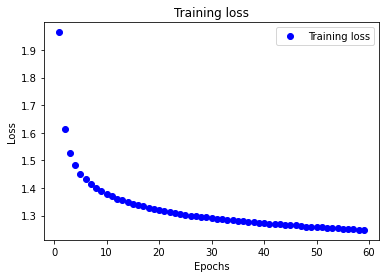

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The plot shows that the loss generally decreases, but there are occasional burst of deteriorating loss. In our case, the lowest loss is at epoch 59, so let's load the weights saved at 59 epochs and use them to generate new text.

**Note that, if you run this notebook, you will probably obtain different results, and even your loss might be much higher or lower. You may obtain different results every time you run the notebook.**

In [19]:
model.load_weights('generation_model_epoch59.h5')

In [20]:
text_seed = "let me be pardoned, as an old philologist who cannot desist from the mischief"[:maxlen]
print("Text seed:", text_seed)
generate_text(model, text_seed)

Text seed: let me be pardoned, as an old philologist who cannot desist 
------ temperature: 0.2
let me be pardoned, as an old philologist who cannot desist and the superiority of the sense of the superiority of the same thing to the same thing to the same thing to the sense of the sense in the same things the strive to be the surpalian to the same thing the superiority of the experience of the same thing to the constantly the superiority of the same thing to the same the world to the same thing to the same thing to the same the strength of the same t
------ temperature: 0.5
let me be pardoned, as an old philologist who cannot desist of the hand the false of the word of the superious of the english and the could in the same than
the experience, and with the last are service is a more one was the sense of the word and for exaction and suld always and with the stronger say to the serving, and allow and he was the present and superious and with the present to the more sympathy throughing f

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


fraites stforthed,
"and
can valulence in tradiatoroned: he he who teswer great and lifes. ;x" this break whithout



As you can see, a low temperature results in extremely repetitive and predictable text, but where local structure is highly realistic: in 
particular, most words (a word being a local pattern of characters) are real English words. With higher temperatures, the generated text 
becomes more interesting, surprising, even creative; it may sometimes invent completely new words that sound somewhat plausible (such as 
"eterned" or "troveration"). With a high temperature, the local structure starts breaking down and most words look like semi-random strings 
of characters. Without a doubt, here 0.5 is the most interesting temperature for text generation in this specific setup. Always experiment 
with multiple sampling strategies! A clever balance between learned structure and randomness is what makes generation interesting.


For your reference, below is the original text by Nietzsche:

```
22. Let me be pardoned, as an old philologist who cannot desist from
the mischief of putting his finger on bad modes of interpretation, but
"Nature's conformity to law," of which you physicists talk so proudly,
as though--why, it exists only owing to your interpretation and bad
"philology." It is no matter of fact, no "text," but rather just a
naively humanitarian adjustment and perversion of meaning, with which
you make abundant concessions to the democratic instincts of the modern
soul! 
```

Note that by training a bigger model, longer, on more data, you can achieve generated samples that will look much more coherent and 
realistic than ours. But of course, don't expect to ever generate any meaningful text, other than by random chance: all we are doing is 
sampling data from a statistical model of which characters come after which characters. Language is a communication channel, and there is 
a distinction between what communications are about, and the statistical structure of the messages in which communications are encoded. To 
evidence this distinction, here is a thought experiment: what if human language did a better job at compressing communications, much like 
our computers do with most of our digital communications? Then language would be no less meaningful, yet it would lack any intrinsic 
statistical structure, thus making it impossible to learn a language model like we just did.




## Take aways

* We can generate discrete sequence data by training a model to predict the next tokens(s) given previous tokens.
* In the case of text, such a model is called a "language model" and could be based on either words or characters.
* Sampling the next token requires balance between adhering to what the model judges likely, and introducing randomness.
* One way to handle this is the notion of _softmax temperature_. Always experiment with different temperatures to find the "right" one.